In [2]:
import chainer
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import os
import pandas as pd
import PIL
import tqdm
%matplotlib inline

In [4]:
chainer.cuda.get_device_from_id(0).use()

In [6]:
class CatDogResNet50(chainer.Chain):
    def __init__(self):
        super(CatDogResNet50, self).__init__()
        with self.init_scope():
            self.resnet50 = chainer.links.ResNet50Layers()
            self.fc_final = chainer.links.Linear(None, 2)
    def __call__(self, x):
        y = self.resnet50(x, layers=['pool5'])['pool5']
        return self.fc_final(y)

model = CatDogResNet50()
chainer.serializers.load_npz('model-1600.npz', model)
model.to_gpu()

In [7]:
data = '../../data/kaggle/dogs-vs-cats-redux-kernels-edition/'
path_test = os.path.join(data, 'test')
test_images = os.listdir(path_test)
test_dataset = chainer.datasets.ImageDataset(test_images, root=path_test)

def Resize(size):
    def transform(image):
        label = None
        if len(image) == 2:
            image, label = image
        image = PIL.Image.fromarray(image.transpose(1, 2, 0).astype(np.uint8))
        image = image.resize(size, PIL.Image.NEAREST)
        if label is None:
            return np.asarray(image).transpose(2, 0, 1).astype(np.float32)
        else:
            return (np.asarray(image).transpose(2, 0, 1).astype(np.float32), label)
    return transform

test_dataset = chainer.datasets.TransformDataset(test_dataset, Resize((224, 224)))
test_dataset.test_images = test_images

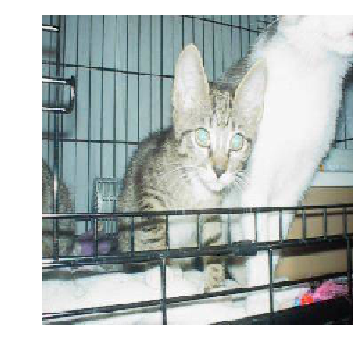

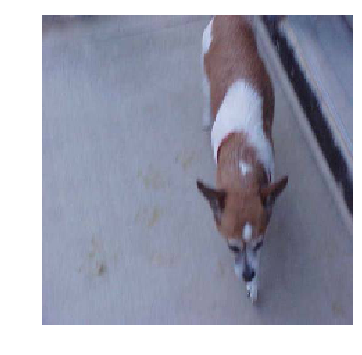

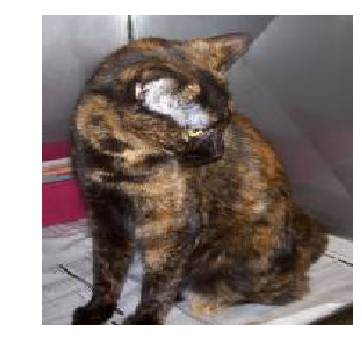

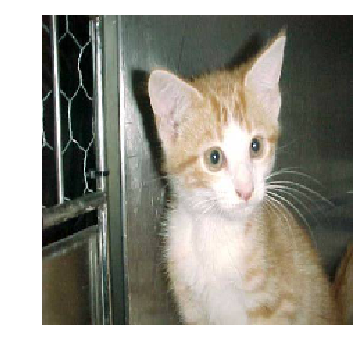

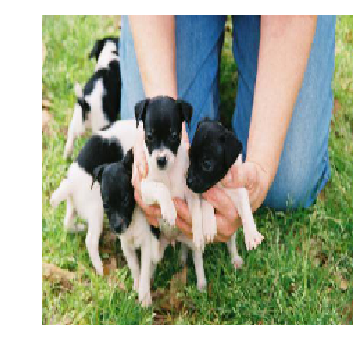

In [8]:
for i in range(5):
    image = test_dataset[i]
    image = np.transpose(image, (1, 2, 0)) / 255.
    plt.figure()
    plt.imshow(image, interpolation='nearest')
    plt.axis('off')
    #plt.title(string_of_label(label))

In [9]:
chainer.functions.softmax(model(model.xp.asarray(test_dataset[:5])))
# we have 0 = dog, 1 = cat here (opposite to what Kaggle expects)
# we want to produce P(dog)

variable([[  1.89788921e-07,   9.99999762e-01],
          [  9.59491432e-01,   4.05085534e-02],
          [  9.98324692e-01,   1.67529227e-03],
          [  1.24526224e-07,   9.99999881e-01],
          [  1.00000000e+00,   1.23103741e-11]])

In [10]:
probas = chainer.functions.softmax(model(model.xp.asarray(test_dataset[:10]))).data
proba_dog = probas[:, 0]
id_image = [int(os.path.splitext(x)[0]) for x in test_dataset.test_images][:len(proba_dog)]
prediction_small = pd.DataFrame(dict(id=id_image, label=list(proba_dog)))
prediction_small.sort_values('id', inplace=True)
prediction_small

,id,label
4,779,1.0
9,1780,0.000272970588412
6,2399,2.23319830184e-06
5,2768,1.0
3,4392,4.88981356739e-07
0,9292,7.58560418035e-07
2,9688,0.999036192894
8,10947,4.33795355193e-09
1,12026,0.963657736778
7,12225,0.999402761459


In [11]:
prediction_small.to_csv('prediction-small.csv', index=False)
!cat prediction-small.csv

id,label
779,1.0
1780,0.000272970588412
2399,2.23319830184e-06
2768,1.0
4392,4.88981356739e-07
9292,7.58560418035e-07
9688,0.999036192894
10947,4.33795355193e-09
12026,0.963657736778
12225,0.999402761459


In [14]:
# now let's create predictions for the complete test dataset, batch by batch
test_iter = chainer.iterators.SerialIterator(test_dataset, batch_size=128, repeat=False, shuffle=False)
probas = []
for batch in tqdm.tqdm(test_iter, total=len(test_dataset)/test_iter.batch_size):
    # .get() converts the GPU array to a CPU one
    proba_dog = chainer.functions.softmax(model(model.xp.asarray(batch))).data[:, 0].get()
    probas.append(proba_dog)
proba_dog = np.concatenate(probas)
id_image = [int(os.path.splitext(x)[0]) for x in test_dataset.test_images]
prediction = pd.DataFrame(dict(id=id_image, label=list(proba_dog)))
prediction.sort_values('id', inplace=True)
prediction

98it [02:18,  1.41s/it]                        


,id,label
7082,1,9.999995e-01
4067,2,1.000000e+00
3558,3,1.000000e+00
5730,4,1.000000e+00
2852,5,3.094962e-05
3896,6,1.572685e-04
9565,7,2.410014e-08
8351,8,3.359199e-05
9270,9,2.499724e-10
6412,10,3.576257e-06


In [15]:
prediction.to_csv('prediction.csv', index=False)
!cat prediction.csv

id,label
1,0.999999523163
2,1.0
3,1.0
4,1.0
5,3.09496244881e-05
6,0.000157268514158
7,2.41001423262e-08
8,3.35919867211e-05
9,2.49972376132e-10
10,3.5762573134e-06
11,3.12866200147e-06
12,0.994997382164
13,3.00115071683e-10
14,0.000149338593474
15,1.54854476464e-10
16,6.00678185947e-06
17,0.999998450279
18,1.0
19,4.52252351124e-07
20,0.000568504096009
21,1.0
22,0.000607830821536
23,1.0
24,0.999846935272
25,3.20028590295e-08
26,0.999990582466
27,1.0
28,2.86822943174e-09
29,0.981774032116
30,0.999999046326
31,0.999999642372
32,0.894271075726
33,0.999934673309
34,0.0192122515291
35,0.000237682193983
36,0.00024329200096
37,1.52171224954e-07
38,3.60095242513e-07
39,0.997771680355
40,1.38426582907e-06
41,0.999981045723
42,1.0
43,1.0
44,0.999799787998
45,1.70777880726e-09
46,0.872794687748
47,5.87914641414e-08
48,1.0
49,1.0
50,0.00181839405559
51,3.66110661787e-08
52,2.95997504285e-10
53,7.56589280115e-09
54,0.0326282642782
55,4.73264876177e-08
56,0.999999642372
57,1.0
58,1.86096229982e-07
59

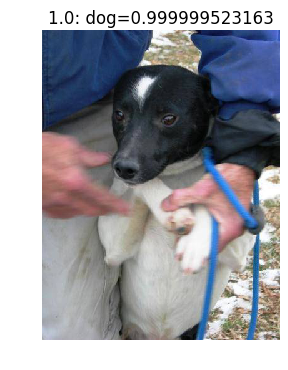

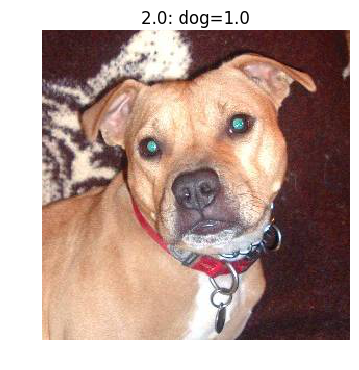

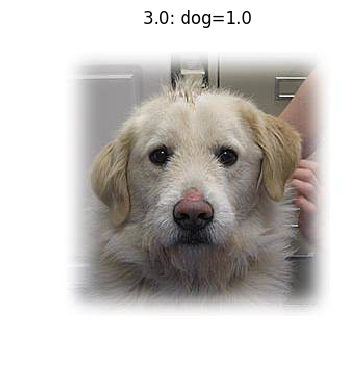

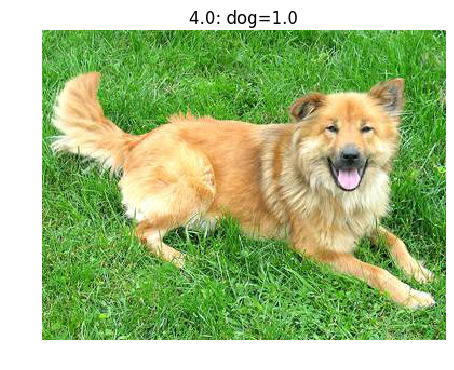

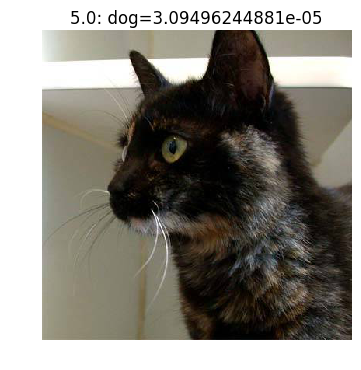

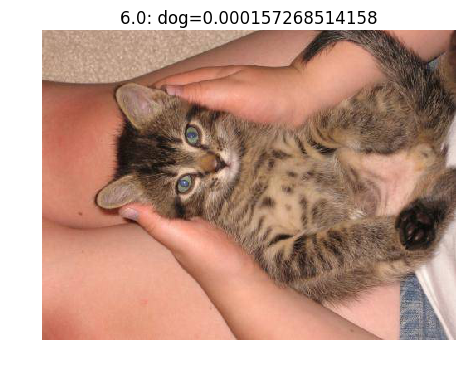

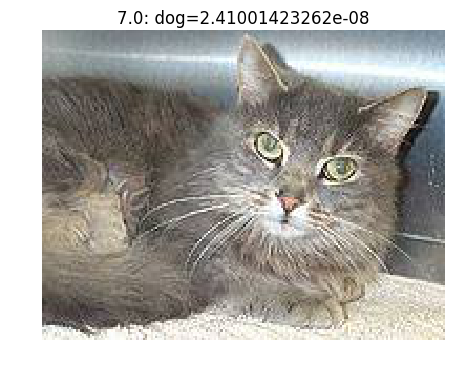

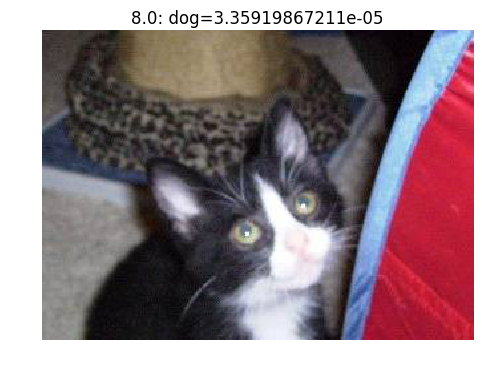

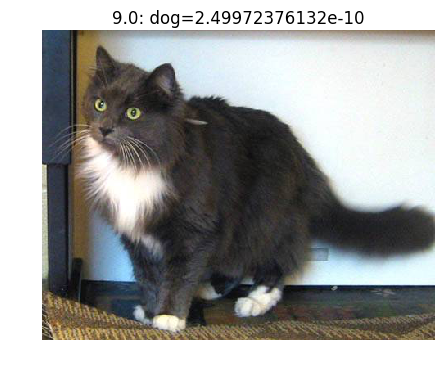

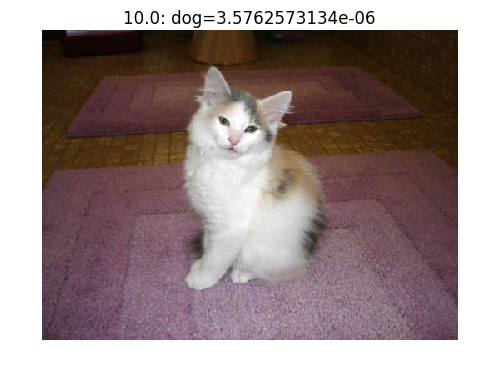

In [16]:
# check that our predictions are not absurd
for _, row in prediction[:10].iterrows():
    image = PIL.Image.open(os.path.join(data, 'test', "{}.jpg".format(int(row.id))))
    plt.figure()
    plt.imshow(image, interpolation='nearest')
    plt.axis('off')
    plt.title("{}: dog={}".format(row.id, row.label))

In [17]:
#!kg submit -m 'initial fast.ai submission (Chainer+ResNet50)' -c dogs-vs-cats-redux-kernels-edition -u ronanronan -p xxxx prediction.csv
# loss 0.17817 gives position 759/1314 = 57%
# target for position 50% (657) is 0.122
#!kg submit -m '2nd fast.ai submission (Chainer+ResNet50, trained for a few epochs)' -c dogs-vs-cats-redux-kernels-edition -u ronanronan -p ESadLavocItcuf9 prediction.csv
# gives 0.18500

0.18500


In [4]:
# convert prediction.csv to 0/1 instead of probabilities
prediction = pd.read_csv("prediction.csv")
prediction_binary = prediction.copy()
prediction_binary.label = (prediction_binary.label > 0.5).astype(np.int)
prediction_binary.to_csv('prediction-binary.csv', index=False)
!cat 'prediction-binary.csv'

id,label
1,1
2,1
3,1
4,1
5,0
6,0
7,0
8,0
9,0
10,0
11,0
12,1
13,0
14,0
15,0
16,0
17,1
18,1
19,0
20,0
21,1
22,0
23,1
24,1
25,0
26,1
27,1
28,0
29,1
30,1
31,1
32,1
33,1
34,0
35,0
36,0
37,0
38,0
39,1
40,0
41,1
42,1
43,1
44,1
45,0
46,1
47,0
48,1
49,1
50,0
51,0
52,0
53,0
54,0
55,0
56,1
57,1
58,0
59,1
60,0
61,0
62,1
63,1
64,0
65,1
66,1
67,1
68,0
69,1
70,1
71,1
72,1
73,1
74,1
75,0
76,1
77,1
78,1
79,1
80,0
81,0
82,0
83,1
84,0
85,1
86,1
87,1
88,1
89,0
90,0
91,0
92,0
93,0
94,1
95,1
96,0
97,1
98,1
99,0
100,0
101,0
102,1
103,0
104,0
105,1
106,1
107,0
108,0
109,1
110,1
111,1
112,1
113,1
114,0
115,0
116,0
117,0
118,1
119,1
120,0
121,0
122,0
123,0
124,0
125,0
126,0
127,1
128,0
129,0
130,0
131,1
132,1
133,0
134,0
135,0
136,0
137,1
138,1
139,1
140,0
141,0
142,1
143,1
144,1
145,0
146,1
147,1
148,1
149,0
150,0
151,1
152,0
153,0
154,0
155,1
156,0
157,0
158,1
159,1
160,1
161,0
162,0
163,0
164,1
165,0
166,0
167,1
168,0
169,0
170,0
171,0
172,1
173,1
174,0
175,1
176,1
177,1
178,1
179,1
180,0
181,1
182,1
183,0
1

In [5]:
#!kg submit -m '2nd fast.ai submission + binarize prediction' -c dogs-vs-cats-redux-kernels-edition -u ronanronan -p ESadLavocItcuf9 prediction-binary.csv
# 1.40920! ouch!

1.40920


In [6]:
484/1314.

0.3683409436834094